# 1D spectral extraction using aperture photometry on a point source observation
In this notebook we illustrate how to perform aperture photometry on LVL2 MRS data products (slope detector images). The algorithm is applied to a point source observation of an 800K blackbody source.

In [1]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# The raw code for this IPython notebook is by default hidden for easier reading.
# To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
from distortionMaps import d2cMapping
from shapely.geometry import Polygon
from shapely.geometry import Point
import shapely.affinity

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# Define the paths to the data
workDir = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir  = workDir+'cdp_data/'
lvl2path  = workDir+'FM_data/LVL2/'

Given an MRS observation in a spectral band of choice, the data are reduced from LVL2 to LVL3. We do this here manually.

In [3]:
# Define filename of observation in selected MRS band
band     = '1A'
sci_file = lvl2path+'FM1T00011453/MIRFM1T00011453_1_495_SE_2011-06-03T21h10m39_LVL2.fits'

In [4]:
# Get data
hdulist_sci   = fits.open(sci_file)
source_signal = hdulist_sci[1].data[0,:,:]

In [5]:
# load distortion map on detector plane
d2cMaps  = d2cMapping(band,cdpDir)
det_dims = (1024,1032)

In [6]:
# load CDPs
fringe_img,photom_img,pixsiz_img,psffits,specres_table,pce_table = funcs.get_cdps(band,cdpDir,output='img')

Calibration steps from LVL2 to LVL3 data include (1) background subtraction, (2) fringe correction, (3) spectrophotometric calibration.

In [7]:
# reduce LVL2 data to LVL3 data
source_signal_subtrbkg  = source_signal - 0                     # [DN/s/pix_{ij}]
source_signal_divfringe = source_signal_subtrbkg/fringe_img     # [DN/s/pix_{ij}]
source_signal_divphotom = source_signal_divfringe/photom_img    # [mJy/pix] (note here that the ij subscript has disappeared as the flat field division has changed the normalization to an average pixel area and responsivity)

To perform the 1D spectral extraction on detector level, a spectral grid is constructed using the wavelength extension of the MRS distortion maps. An aperture is defined using the spatial extension of the distortion maps.

In [9]:
# create spectral grid on detector
lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table) # follow the spectral resolution
# lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table,spacing='constant') # constant spectral grid width
print('There are {} spectral bins'.format(len(lambcens)))

There are 598 spectral bins


A default radius is assumed for the aperture in the case of a point source observation. That is, the default radius is the radius needed to achieve eighty-percent encircled energy on the MRS PSF. This quantity depends on wavelength, and has been pre-computed. Thus we only need to load the values.

<IPython.core.display.Javascript object>


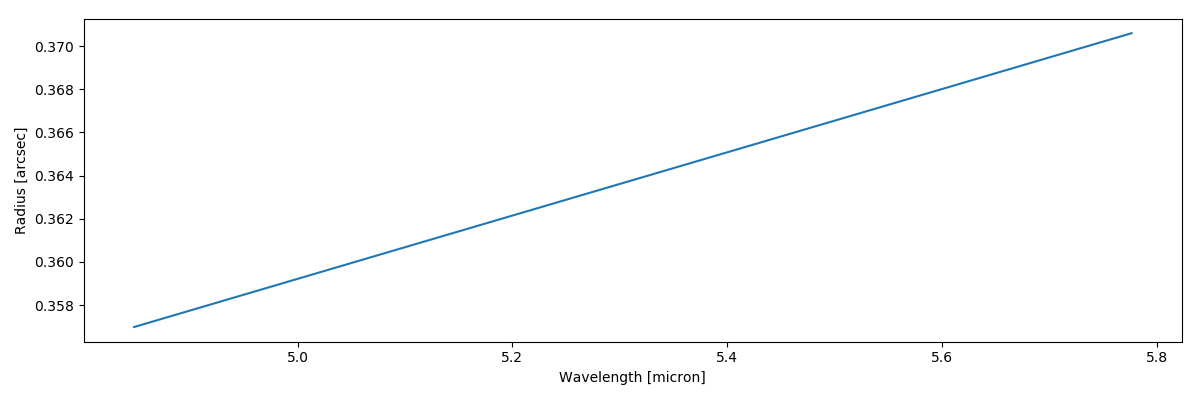

In [10]:
eighty_percent_encircled_energy_fraction = funcs.load_obj('eighty_percent_encircled_energy_fraction_aperture_radius_band{}'.format(band))
popt = np.polyfit(lambcens,eighty_percent_encircled_energy_fraction[1:],1)
radius_poly = np.poly1d(popt)

plt.figure(figsize=(12,4))
plt.plot(lambcens,radius_poly(lambcens))
plt.xlabel('Wavelength [micron]')
plt.ylabel('Radius [arcsec]')
plt.tight_layout()

# overwrite radius
radius = 0.75 # arcsecond

To center the aperture we need to define the centroid of the point source.

<IPython.core.display.Javascript object>


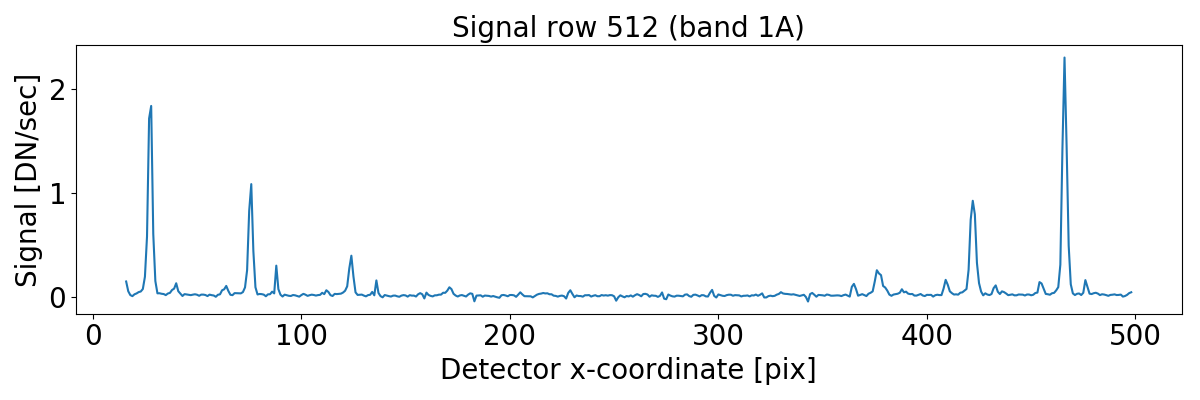

In [15]:
row = 512
plt.figure(figsize=(12,4))
plt.plot(source_signal_divphotom[row,:512])
plt.xlabel('Detector x-coordinate [pix]',fontsize=20)
plt.ylabel('Signal [DN/sec]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.title('Signal row {} (band {})'.format(row,band),fontsize=20)
plt.tight_layout()

<IPython.core.display.Javascript object>


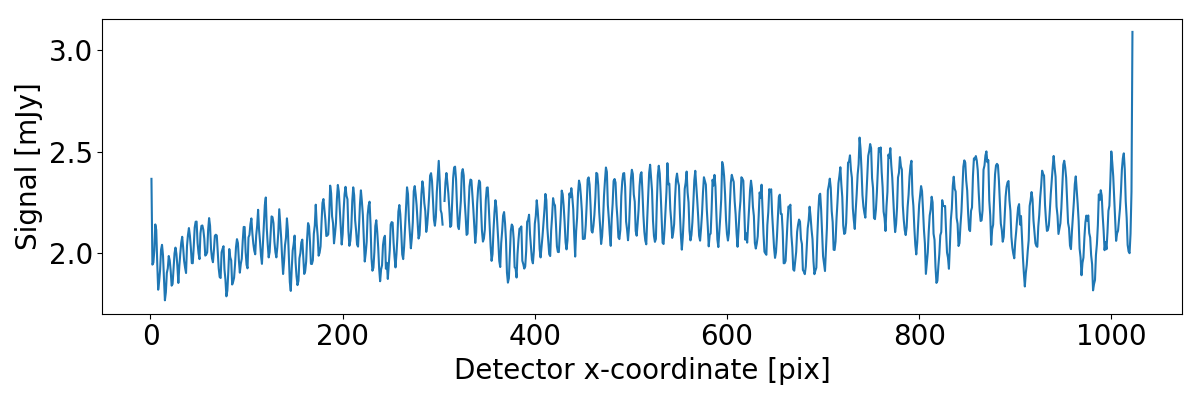

<IPython.core.display.Javascript object>


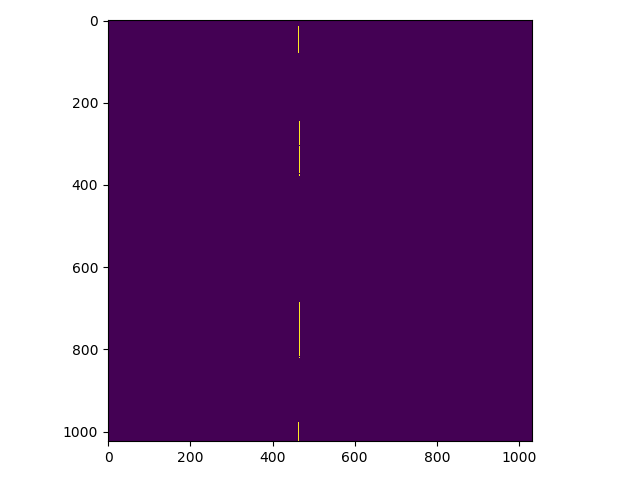

In [16]:
ypos,xpos = funcs.detpixel_trace_compactsource(source_signal_subtrbkg,band,d2cMaps)

plt.figure(figsize=(12,4))
plt.plot(source_signal_divphotom[ypos,xpos])
plt.xlabel('Detector x-coordinate [pix]',fontsize=20)
plt.ylabel('Signal [mJy]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

validMap = np.zeros(det_dims)
validMap[ypos,xpos] = 1

plt.figure()
plt.imshow(validMap)
plt.tight_layout()

In [11]:
if band[0] == '4': fit = '1D'
else: fit = '2D'

if band[0] == '4':
    sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta,bkg_amp = funcs.point_source_centroiding(band,source_signal_subtrbkg,d2cMaps,spec_grid=[lambcens,lambfwhms],fit=fit)
    if len(np.where(np.isnan(sign_amp)==True)[0]) > len(lambcens)/2:
        # too many nans.. last attempt
        sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta,bkg_amp = funcs.point_source_centroiding(band,source_signal_subtrbkg,d2cMaps,spec_grid=[lambcens,lambfwhms],fit=fit,center=[d2cMaps['nslices']/2 +1,0.])
else:
    sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta,bkg_amp = funcs.point_source_centroiding(band,source_signal_divfringe,d2cMaps,spec_grid=[lambcens,lambfwhms],fit=fit)

source_alpha_center = np.mean(alpha_centers[~np.isnan(alpha_centers)])
source_beta_center  = np.mean(beta_centers[~np.isnan(beta_centers)])

STEP 1: Rough centroiding
Slice 12 has the largest summed flux
Source position: beta = 0.18arcsec, alpha = -0.18arcsec 

STEP 2: 1D Gaussian fit
[Along-slice fit] The following bins failed to converge:
[0, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597]
[Across-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597]

STEP 3: 2D Gaussian fit
The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 38, 39, 40, 42, 120, 121, 122, 196, 202, 294, 295, 303, 304, 305, 344, 345, 346, 347, 370, 371, 372, 373, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597]


<IPython.core.display.Javascript object>


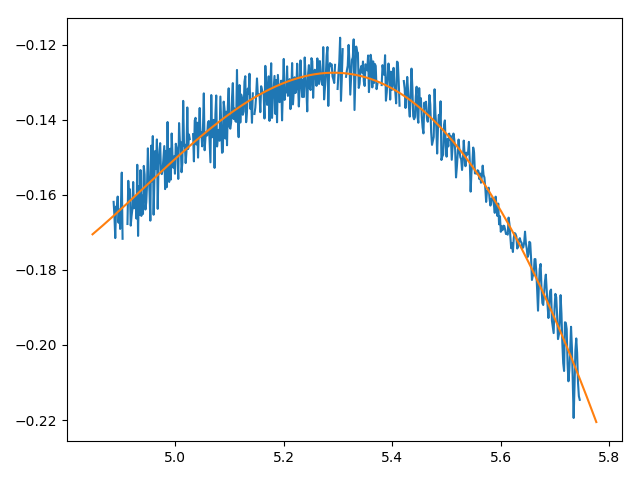

<IPython.core.display.Javascript object>


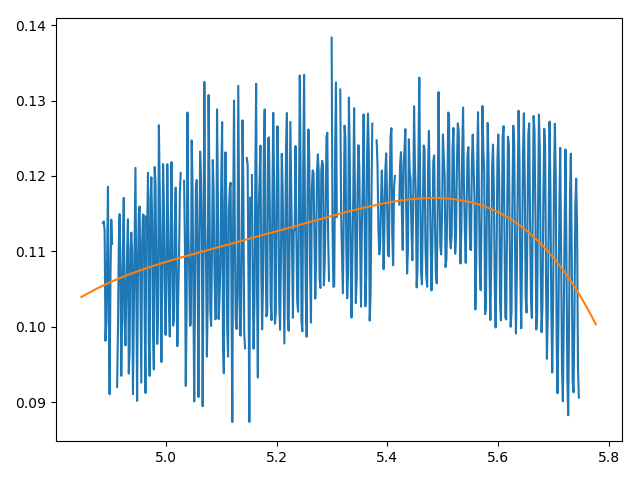

In [12]:
popt = np.polyfit(lambcens[~np.isnan(alpha_centers)],alpha_centers[~np.isnan(alpha_centers)],4)
alpha_poly = np.poly1d(popt)
popt = np.polyfit(lambcens[~np.isnan(beta_centers)],beta_centers[~np.isnan(beta_centers)],4)
beta_poly = np.poly1d(popt)

plt.figure()
plt.plot(lambcens,alpha_centers)
plt.plot(lambcens,alpha_poly(lambcens))
plt.tight_layout()

plt.figure()
plt.plot(lambcens,beta_centers)
plt.plot(lambcens,beta_poly(lambcens))
plt.tight_layout()

<IPython.core.display.Javascript object>


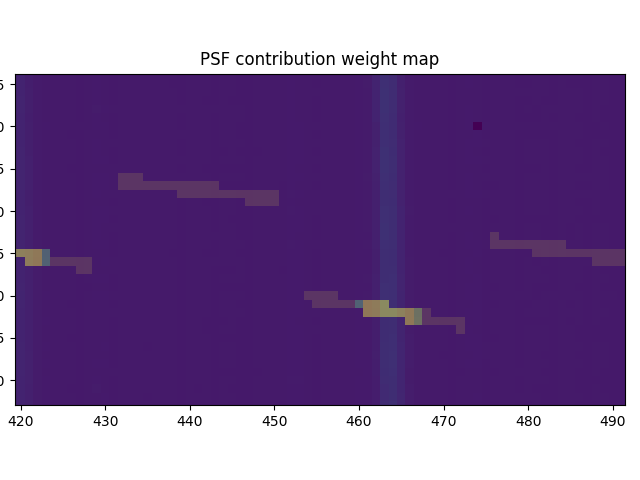

In [14]:
# perform example calculation in one spectral bin
ibin = 100

#--delineate spectral bin
i,j = np.where(np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)
BinMask = np.zeros(det_dims); BinMask[i,j] = 1.

#--define basic aperture parameters
# 1st elem = center point (x,y) coordinates
# 2nd elem = the two semi-axis values (along x, along y)
# 3rd elem = angle in degrees between x-axis of the Cartesian base
#            and the corresponding semi-axis
aper_params = ((alpha_poly(lambcens[ibin]), beta_poly(lambcens[ibin])),(1,1),0)

# Let's create a circle of specified radius around specified aperture center:
circ = shapely.geometry.Point(aper_params[0]).buffer(radius) # .buffer(radius_poly(lambcens[ibin]))

# Let's create the ellipse along x and y:
ellipse  = shapely.affinity.scale(circ, int(aper_params[1][0]), int(aper_params[1][1]))

# Let rotate the ellipse (clockwise, x axis pointing right):
ellrot = shapely.affinity.rotate(ellipse,aper_params[2])

# save final output as the aperture and calculate the aperture area
aperture = ellrot
aperture_area = aperture.area

# define slicer-projected polygon/trapezoid (in IFU alpha-beta coordinates) for each pixel
weight_map = np.zeros((1024,1032))
for ij in zip(i,j):
    xy = [[d2cMaps['alphaURMap'][ij],d2cMaps['betaURMap'][ij]], 
          [d2cMaps['alphaULMap'][ij],d2cMaps['betaULMap'][ij]], 
          [d2cMaps['alphaLLMap'][ij],d2cMaps['betaLLMap'][ij]], 
          [d2cMaps['alphaLRMap'][ij],d2cMaps['betaLRMap'][ij]]]
    polygon_shape = Polygon(xy)

    # derive weight as ratio between the area of intersection of the trapezoid and the aperture, and the trapezoid area
    weight_map[ij] = polygon_shape.intersection(aperture).area/polygon_shape.area

plt.figure()
plt.title('PSF contribution weight map')
plt.imshow(weight_map)
plt.imshow(BinMask,alpha=0.3)
plt.imshow(source_signal_divphotom,alpha=0.6)
plt.tight_layout()

In [15]:
sci_img = source_signal_divphotom.copy()
sci_img[np.isnan(sci_img)] = 0
signals_aper = np.zeros(len(lambcens))
for ibin in range(len(lambcens)):
    # map containing only pixels within one spectral bin, within the defined aperture, omitting NaNs
    i,j = np.where(np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)
    
    # define aperture shape
    # 1st elem = center point (x,y) coordinates
    # 2nd elem = the two semi-axis values (along x, along y)
    # 3rd elem = angle in degrees between x-axis of the Cartesian base
    #            and the corresponding semi-axis
    if (np.isnan(source_alpha_center)) or (np.isnan(source_beta_center) is True):
        raise 'Invalid centroid! Center is NaN!'
    aper_params = ((alpha_poly(lambcens[ibin]), beta_poly(lambcens[ibin])),(1,1),0)

    # Let's create a circle of specified radius around specified aperture center:
    circ = shapely.geometry.Point(aper_params[0]).buffer(radius) # .buffer(radius_poly(lambcens[ibin]))

    # Let create the ellipse along x and y:
    ellipse  = shapely.affinity.scale(circ, int(aper_params[1][0]), int(aper_params[1][1]))

    # Let rotate the ellipse (clockwise, x axis pointing right):
    ellrot = shapely.affinity.rotate(ellipse,aper_params[2])

    # save final output as the aperture and calculate the aperture area
    aperture = ellrot
    aperture_area = aperture.area

    weight_map = np.zeros((1024,1032))
    for ij in zip(i,j):
        xy = [[d2cMaps['alphaURMap'][ij],d2cMaps['betaURMap'][ij]], 
              [d2cMaps['alphaULMap'][ij],d2cMaps['betaULMap'][ij]], 
              [d2cMaps['alphaLLMap'][ij],d2cMaps['betaLLMap'][ij]], 
              [d2cMaps['alphaLRMap'][ij],d2cMaps['betaLRMap'][ij]]]
        polygon_shape = Polygon(xy)
        # derive weight as ratio between the area of intersection of the trapezoid and the aperture, and the trapezoid area
        weight_map[ij] = polygon_shape.intersection(aperture).area/polygon_shape.area
    
    # map containing only pixels within one spectral bin, within the defined aperture
    sci_img_masked = sci_img[i,j]*weight_map[i,j]
    
    # perform aperture photometry
    signals_aper[ibin] = sci_img_masked.sum()

In [78]:
sci_img = source_signal_divphotom.copy()
sci_img[np.isnan(sci_img)] = 0

spectralsizeMap = abs(d2cMaps['lambdaULMap']-d2cMaps['lambdaLRMap'])

signals_aper = np.zeros(len(lambcens))
for ibin in range(len(lambcens)):
    if ibin%100 == 0: print( '{}/{} bins processed'.format(ibin,len(lambcens)))
    # map containing only pixels within one spectral bin, within the defined aperture, omitting NaNs
    i,j = np.where(np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)
    
    # define aperture shape
    # 1st elem = center point (x,y) coordinates
    # 2nd elem = the two semi-axis values (along x, along y)
    # 3rd elem = angle in degrees between x-axis of the Cartesian base
    #            and the corresponding semi-axis
    if (np.isnan(source_alpha_center)) or (np.isnan(source_beta_center) is True):
        raise 'Invalid centroid! Center is NaN!'
    aper_params = ((alpha_poly(lambcens[ibin]), beta_poly(lambcens[ibin])),(1,1),0)

    # Let's create a circle of specified radius around specified aperture center:
    circ = shapely.geometry.Point(aper_params[0]).buffer(radius_poly(lambcens[ibin]))

    # Let create the ellipse along x and y:
    ellipse  = shapely.affinity.scale(circ, int(aper_params[1][0]), int(aper_params[1][1]))

    # Let rotate the ellipse (clockwise, x axis pointing right):
    ellrot = shapely.affinity.rotate(ellipse,aper_params[2])

    # save final output as the aperture and calculate the aperture area
    aperture = ellrot
    aperture_area = aperture.area

    weight_map = np.zeros((1024,1032))
    for ij in zip(i,j):
        xy = [[d2cMaps['alphaURMap'][ij],d2cMaps['betaURMap'][ij]], 
              [d2cMaps['alphaULMap'][ij],d2cMaps['betaULMap'][ij]], 
              [d2cMaps['alphaLLMap'][ij],d2cMaps['betaLLMap'][ij]], 
              [d2cMaps['alphaLRMap'][ij],d2cMaps['betaLRMap'][ij]]]
        polygon_shape = Polygon(xy)
        # derive weight as ratio between the area of intersection of the trapezoid and the aperture, and the trapezoid area
        weight_map[ij] = polygon_shape.intersection(aperture).area/polygon_shape.area
    
    # map containing only pixels within one spectral bin, within the defined aperture
    
    sci_img_masked = (sci_img*weight_map*spectralsizeMap*pixsiz_img)[i,j]
    
    # perform aperture photometry
    signals_aper[ibin] = sci_img_masked.sum()/(spectralsizeMap[i,j].sum()*pixsiz_img[i,j].sum())

0/598 bins processed
100/598 bins processed
200/598 bins processed
300/598 bins processed
400/598 bins processed
500/598 bins processed


<IPython.core.display.Javascript object>


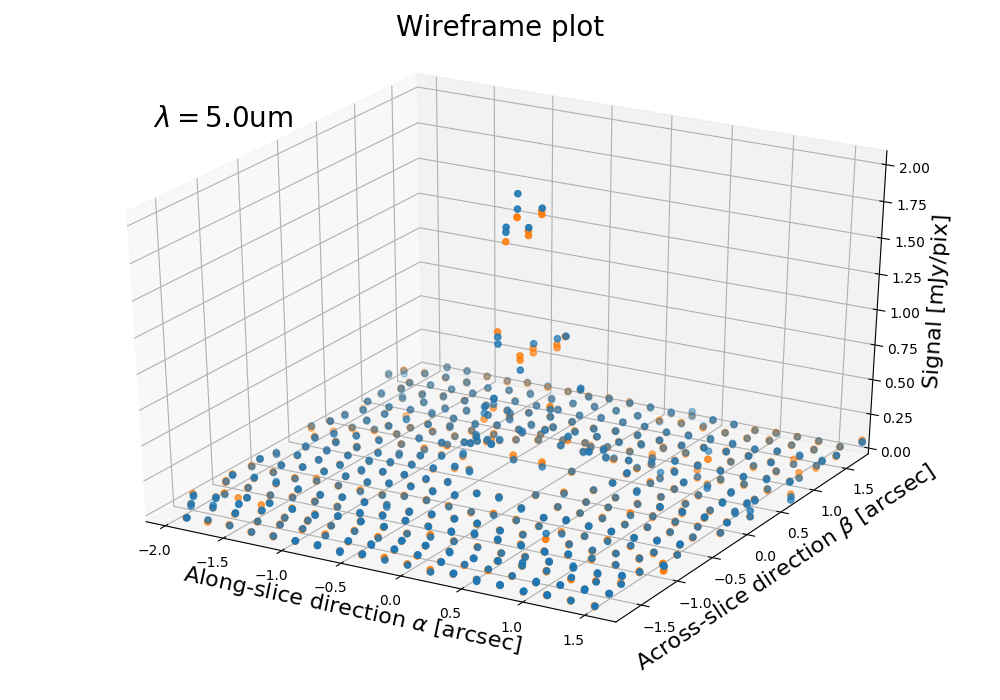

In [98]:
plt.close('all')
ibin = 100

coords = (np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)
alphas, betas, zobs   = d2cMaps['alphaMap'][coords],d2cMaps['betaMap'][coords],source_signal_divphotom[coords]

ibin2 = 101

coords = (np.abs(d2cMaps['lambdaMap']-lambcens[ibin2])<lambfwhms[ibin2]/2.)
alphas2, betas2, zobs2   = d2cMaps['alphaMap'][coords],d2cMaps['betaMap'][coords],source_signal_divphotom[coords]

# make wireframe plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
ax.scatter(alphas, betas, zobs)
ax.scatter(alphas2, betas2, zobs2)
ax.set_xlim(fov_lims[0],fov_lims[1])
ax.set_ylim(unique_betas.min(),unique_betas.max())
ax.set_zlim(0)
ax.set_xlabel(r'Along-slice direction $\alpha$ [arcsec]',fontsize=16)
ax.set_ylabel(r'Across-slice direction $\beta$ [arcsec]',fontsize=16)
ax.set_zlabel(r'Signal [mJy/pix]',fontsize=16)
ax.text2D(0.14, 0.85, r'$\lambda =$'+str(round(lambcens[ibin],2))+'um', transform=ax.transAxes,fontsize=20)
ax.tick_params(axis='both',labelsize=10)
plt.suptitle('Wireframe plot',fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

<IPython.core.display.Javascript object>


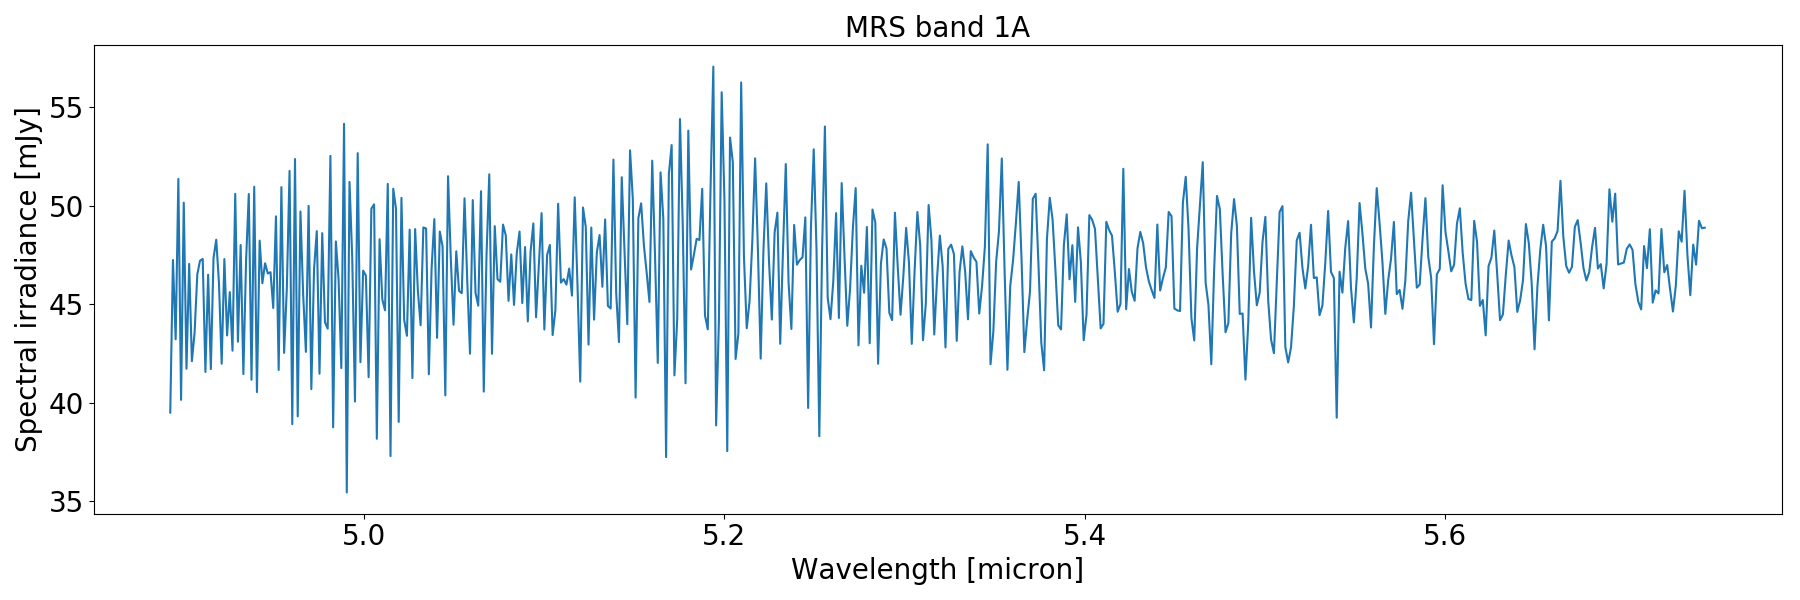

In [17]:
# plot extracted spectrum
plt.figure(figsize=(18,6))
plt.plot(lambcens[30:-20],signals_aper[30:-20]*1.2/(norm_factor[30:-20]/2.))
# plt.plot(lambcens[30:-20],nPixels[30:-20]/30000000.)
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel(r'Spectral irradiance [mJy]',fontsize=20)
plt.title('MRS band {}'.format(band),fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

In [21]:
# define aperture shape
# 1st elem = center point (x,y) coordinates
# 2nd elem = the two semi-axis values (along x, along y)
# 3rd elem = angle in degrees between x-axis of the Cartesian base
#            and the corresponding semi-axis
if (np.isnan(source_alpha_center)) or (np.isnan(source_beta_center) is True):
    raise 'Invalid centroid! Center is NaN!'
aper_params = ((source_alpha_center, source_beta_center),(1,1),0)

# Let create a circle of radius 1 around center point:
circ = shapely.geometry.Point(aper_params[0]).buffer(radius)

# Let create the ellipse along x and y:
ellipse  = shapely.affinity.scale(circ, int(aper_params[1][0]), int(aper_params[1][1]))

# Let rotate the ellipse (clockwise, x axis pointing right):
ellrot = shapely.affinity.rotate(ellipse,aper_params[2])

# save final output as the aperture and calculate the aperture area
aperture = ellrot
aperture_area = aperture.area

NameError: name 'radius' is not defined

Each pixel on the detector has a fractional area overlap with the defined aperture. This percentage is used to weigh the signal contribution of a pixel to the total flux of the source in any given spectral bin.

In [128]:
# create weight map with the pixel signal contributions (percentage area overlap with defined aperture)
weight_map = funcs.pixel_signal_contribution(d2cMaps,aperture,spec_grid=[lambcens,lambfwhms])

Pixel weight mapping
0/599 bins processed
100/599 bins processed
200/599 bins processed
300/599 bins processed
400/599 bins processed
500/599 bins processed
599/599 bins processed


<IPython.core.display.Javascript object>


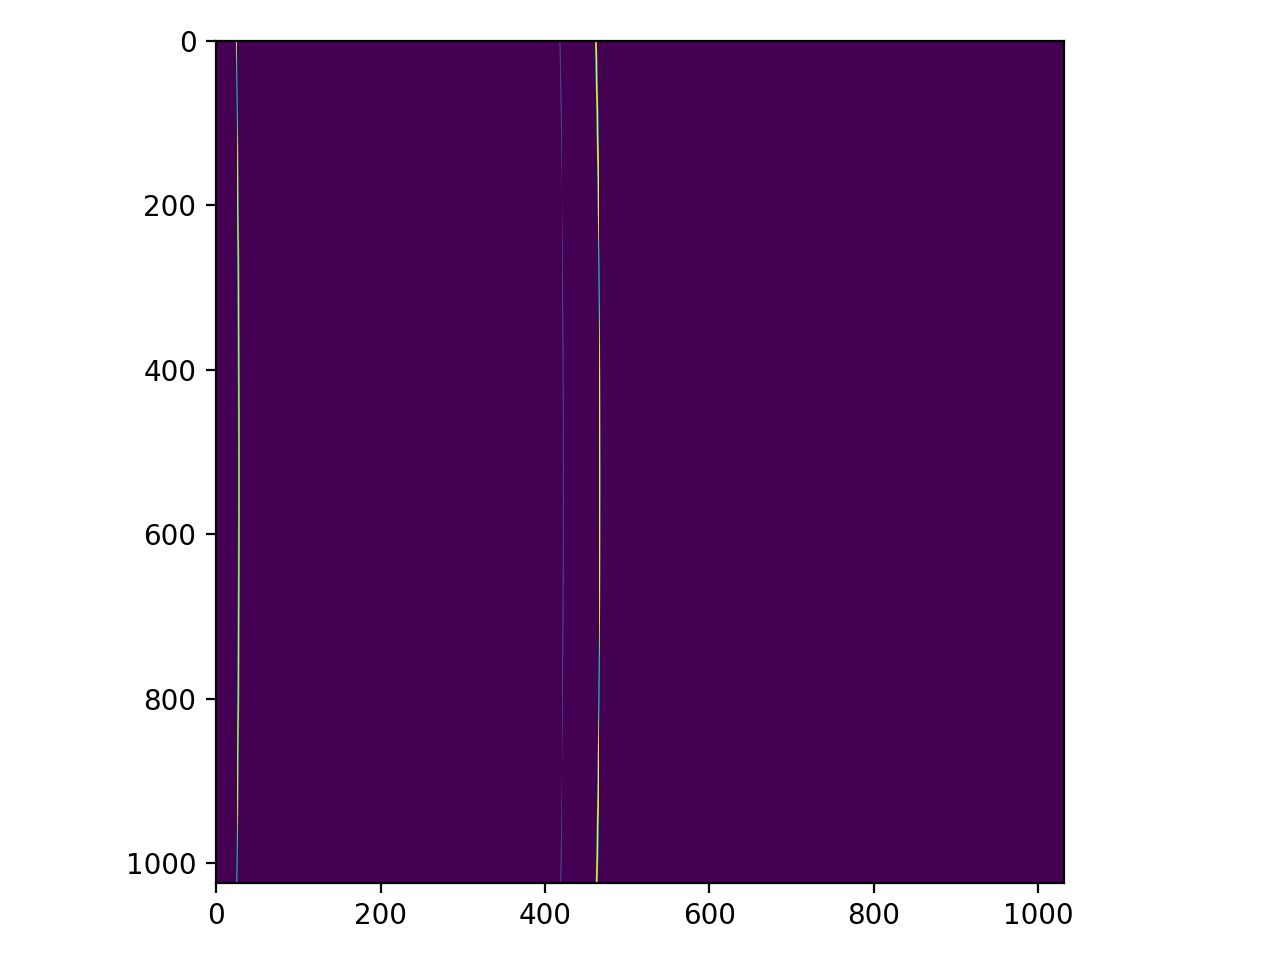

In [129]:
plt.figure()
plt.imshow(weight_map)
plt.tight_layout()

Aperture extraction is performed in each spectral bin by multiplying the signal of the contributing pixels by their respective weights. The signals are then summed.

In [131]:
# perform 1d aperture extraction
extracted_signal = aperture_weighted_photometry_point_source(source_signal_subtrbkg,weight_map,d2cMaps,spec_grid=[lambcens,lambfwhms])

[  3.33502553e-02   2.66905259e-02   1.83503646e-02   3.99535662e-03
   1.15266331e-02   1.74451934e-03   4.03128052e-03  -1.53277926e-02
   9.17938910e-03   3.00785084e-03  -1.30396255e-03   9.12633166e-03
   4.08846661e-02   3.98571305e-02   6.89429343e-02   1.00465409e-01
   7.09910765e-02   2.25594901e-02   6.44320482e-03  -1.57992188e-02
   6.33038953e-03   1.00698406e-02   4.00823401e-03  -2.19436083e-03
   5.11766598e-03  -1.39788250e-02   1.75185781e-02   9.43153445e-03
  -7.44180707e-03  -1.74682662e-02   7.67287984e-03   1.82679836e-02
   3.46034355e-02   2.59057470e-02   4.02311683e-02   3.93591858e-02
   3.44116688e-02   1.23342024e-02   1.67374779e-02   9.09554213e-03
   4.46562422e-03  -1.50162186e-02   1.08447755e-02   1.82656553e-02
   9.64292698e-03  -2.46929051e-03  -1.92168653e-02   1.15091242e-02
   1.19715389e-02   1.69687085e-02   3.00644129e-03   1.41044976e-02
   2.93236654e-02   1.46555984e-02  -6.65584533e-03   1.86114255e-02
   2.46104170e-02   8.80621187e-03

In [16]:
unique_betas = np.sort(np.unique(d2cMaps['betaMap'][(d2cMaps['sliceMap']>100*int(band[0])) & (d2cMaps['sliceMap']<100*(int(band[0])+1))]))

nPixels,norm_factor,spatial_sum,fov_bin = [np.zeros(len(lambcens)) for i in range(4)]
for ibin in range(len(lambcens)):
    pixelsInBin = (np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)
    nPixels[ibin] = len(np.where(np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)[0])
    fov_lims = [d2cMaps['alphaMap'][pixelsInBin].min(),d2cMaps['alphaMap'][pixelsInBin].max()]
    fov_bin[ibin]  = (unique_betas.max()-unique_betas.min())*(fov_lims[1]-fov_lims[0])
    spatial_sum[ibin] = pixsiz_img[pixelsInBin].sum()
    norm_factor[ibin] = (spatial_sum[ibin]/fov_bin[ibin])

<IPython.core.display.Javascript object>


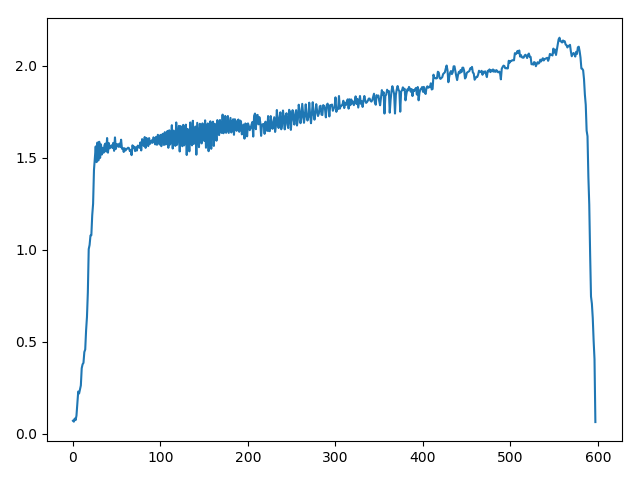

In [107]:
plt.figure()
plt.plot(norm_factor)
plt.tight_layout()

In [32]:
spatial_sum = np.zeros(len(lambcens))
for ibin in range(len(lambcens)):
    # map containing only pixels within one spectral bin, within the defined aperture, omitting NaNs
    i,j = np.where(np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)
    
    # define aperture shape
    # 1st elem = center point (x,y) coordinates
    # 2nd elem = the two semi-axis values (along x, along y)
    # 3rd elem = angle in degrees between x-axis of the Cartesian base
    #            and the corresponding semi-axis
    if (np.isnan(source_alpha_center)) or (np.isnan(source_beta_center) is True):
        raise 'Invalid centroid! Center is NaN!'
    aper_params = ((alpha_poly(lambcens[ibin]), beta_poly(lambcens[ibin])),(1,1),0)

    # Let's create a circle of specified radius around specified aperture center:
    circ = shapely.geometry.Point(aper_params[0]).buffer(radius)

    # Let create the ellipse along x and y:
    ellipse  = shapely.affinity.scale(circ, int(aper_params[1][0]), int(aper_params[1][1]))

    # Let rotate the ellipse (clockwise, x axis pointing right):
    ellrot = shapely.affinity.rotate(ellipse,aper_params[2])

    # save final output as the aperture and calculate the aperture area
    aperture = ellrot
    aperture_area = aperture.area

    weight_map = np.zeros((1024,1032))
    for ij in zip(i,j):
        xy = [[d2cMaps['alphaURMap'][ij],d2cMaps['betaURMap'][ij]], 
              [d2cMaps['alphaULMap'][ij],d2cMaps['betaULMap'][ij]], 
              [d2cMaps['alphaLLMap'][ij],d2cMaps['betaLLMap'][ij]], 
              [d2cMaps['alphaLRMap'][ij],d2cMaps['betaLRMap'][ij]]]
        polygon_shape = Polygon(xy)
        # derive weight as ratio between the area of intersection of the trapezoid and the aperture, and the trapezoid area
        weight_map[ij] = polygon_shape.intersection(aperture).area/polygon_shape.area
    
    # map containing only pixels within one spectral bin, within the defined aperture
    pixel_FoV_contribution = pixsiz_img[i,j]*weight_map[i,j]

    # perform aperture photometry
    spatial_sum[ibin] = pixel_FoV_contribution.sum()

<IPython.core.display.Javascript object>


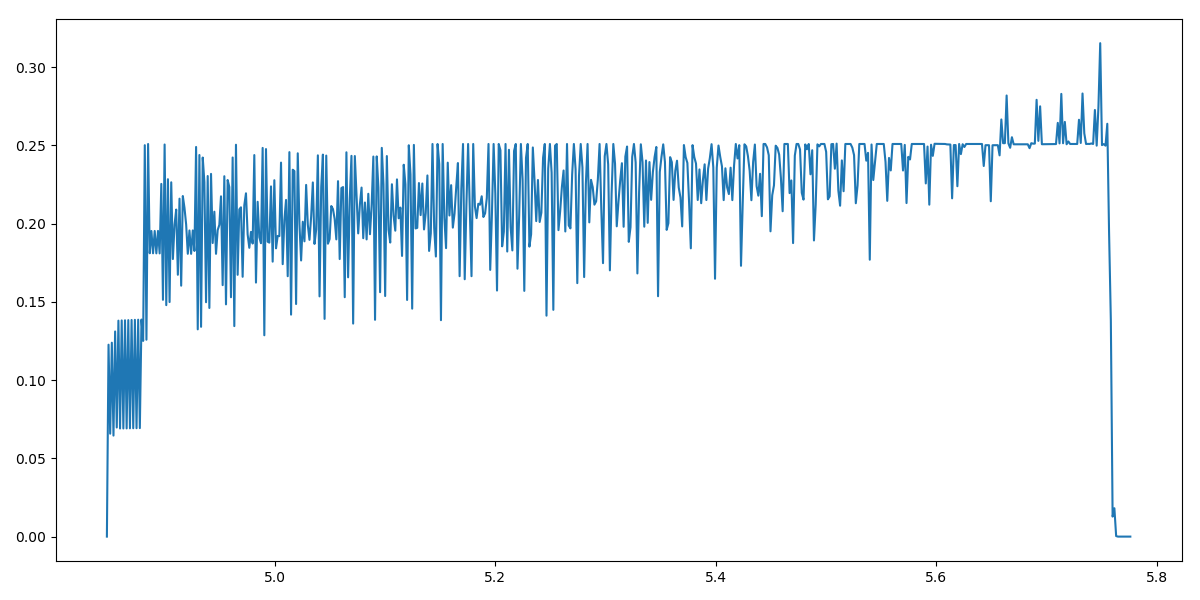

In [34]:
# plot extracted spectrum
plt.figure(figsize=(12,6))
plt.plot(lambcens,spatial_sum)
plt.tight_layout()

In [36]:
# aperture correction based on 80% encircled energy fraction radius
aperture_correction = 1.2

In [95]:
# normalize aperture extracted signal
aperture_extracted_signal = extracted_signal * aperture_correction / norm_factor

Let's plot the extracted 1D spectrum.

<IPython.core.display.Javascript object>


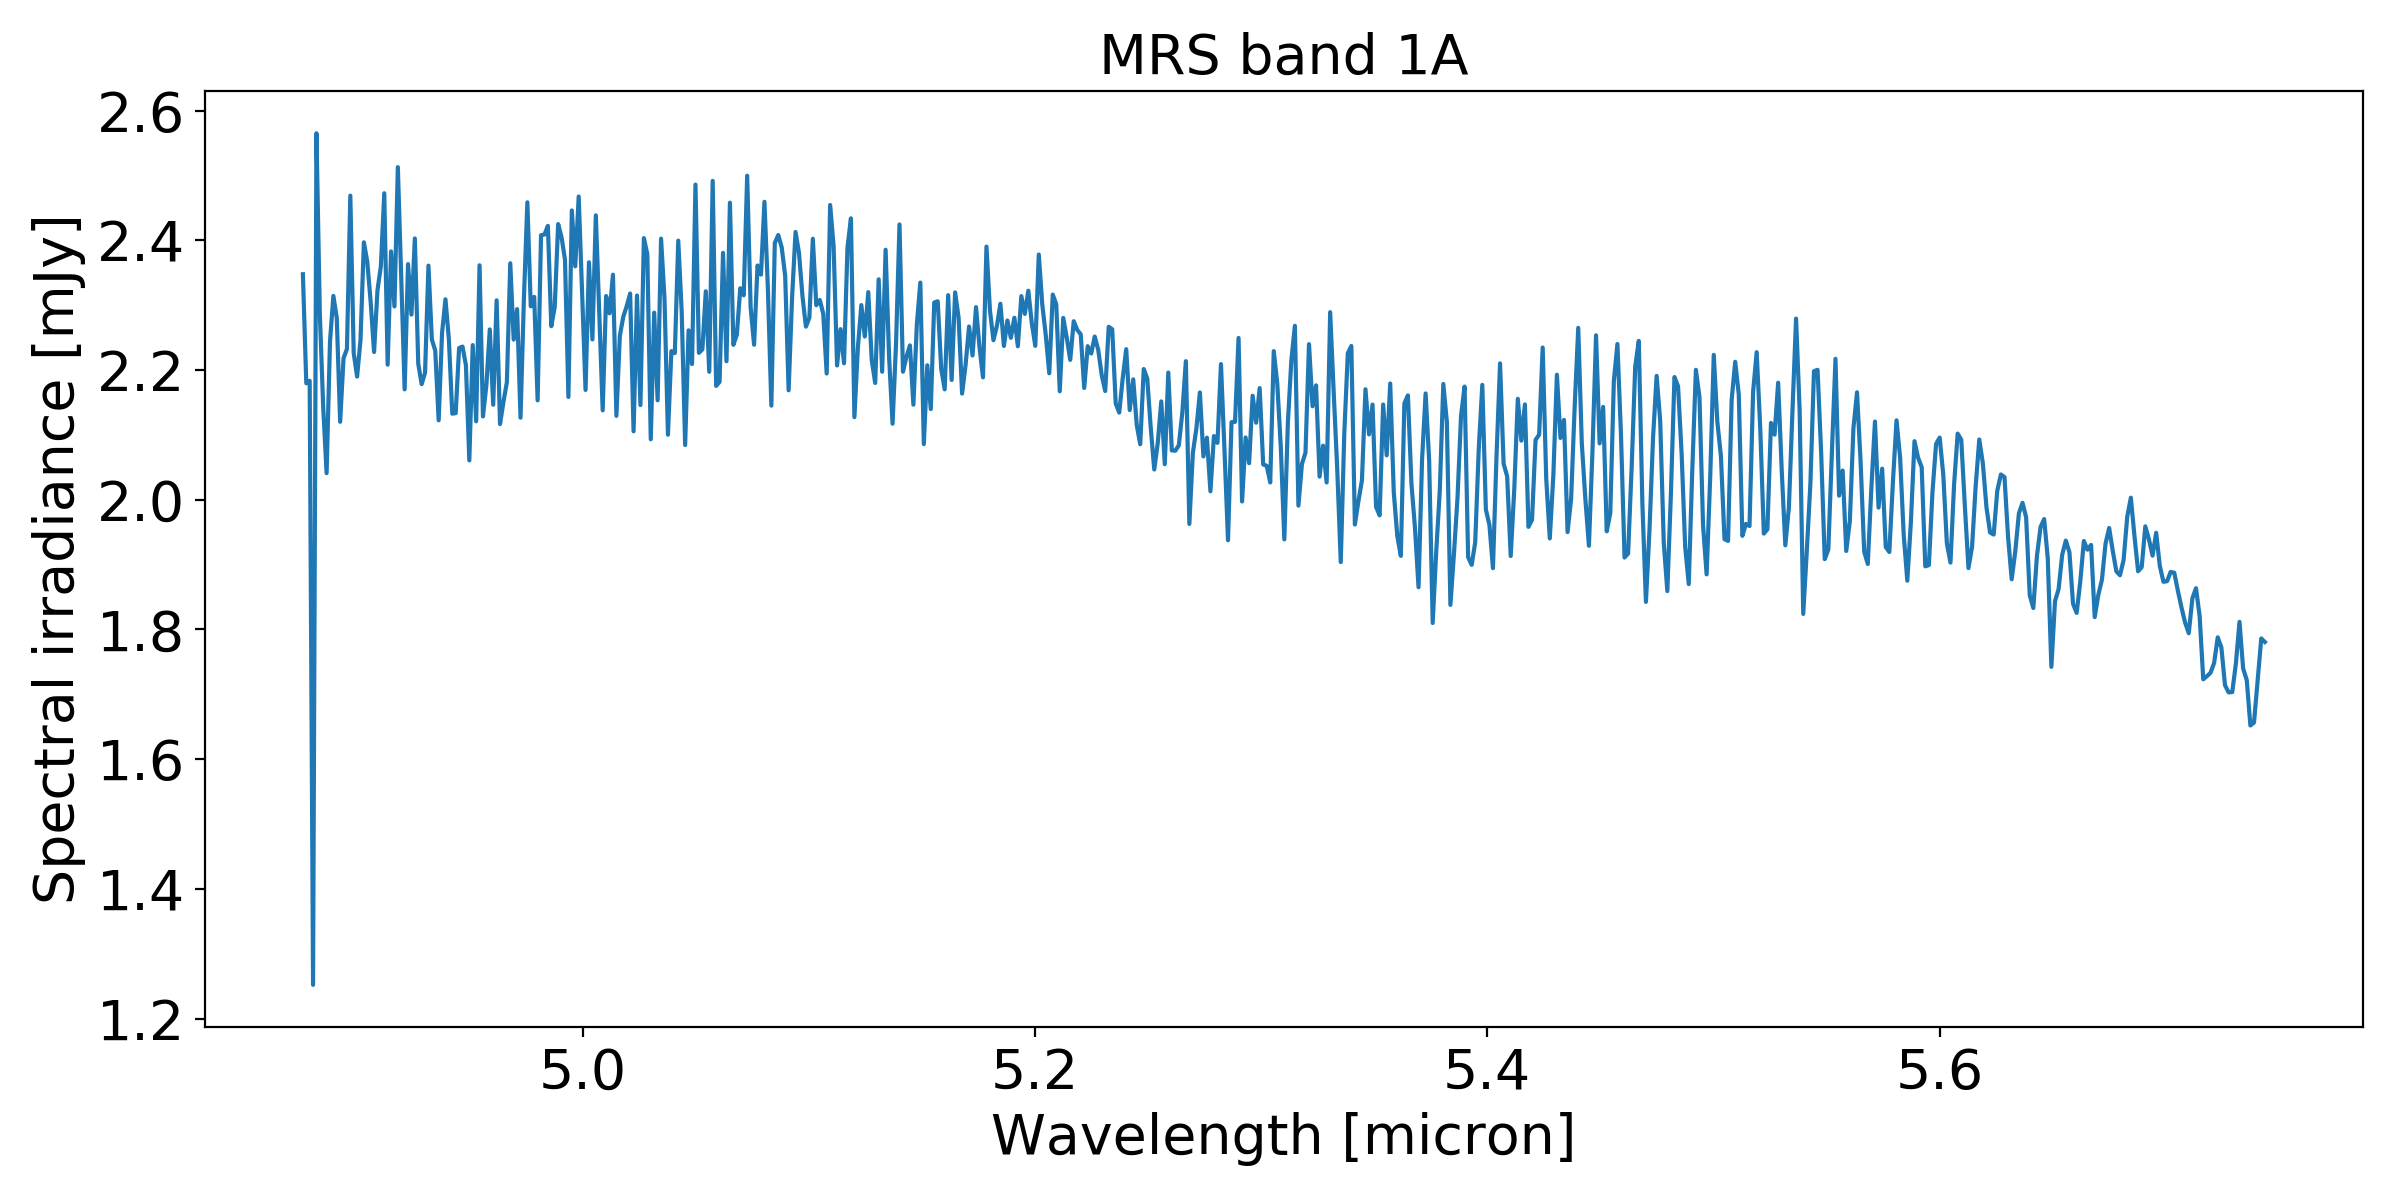

In [132]:
# plot extracted spectrum
plt.figure(figsize=(12,6))
plt.plot(lambcens[20:-20],extracted_signal[20:-20])
# plt.plot(lambcens[20:-20],extracted_signal[20:-20]*1.2)
# plt.plot(lambcens[20:-20],aperture_extracted_signal[20:-20],alpha=0.9)
# plt.plot(lambcens[20:-20],(aperture_extracted_signal*norm_factor)[20:-20],alpha=0.9)
# plt.plot(d2cMaps['lambdaMap'][ypos,xpos],source_signal_subtrbkg[ypos,xpos]/photom_img[ypos,xpos]/fringe_img[ypos,xpos])
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel(r'Spectral irradiance [mJy]',fontsize=20)
plt.title('MRS band {}'.format(band),fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

<IPython.core.display.Javascript object>


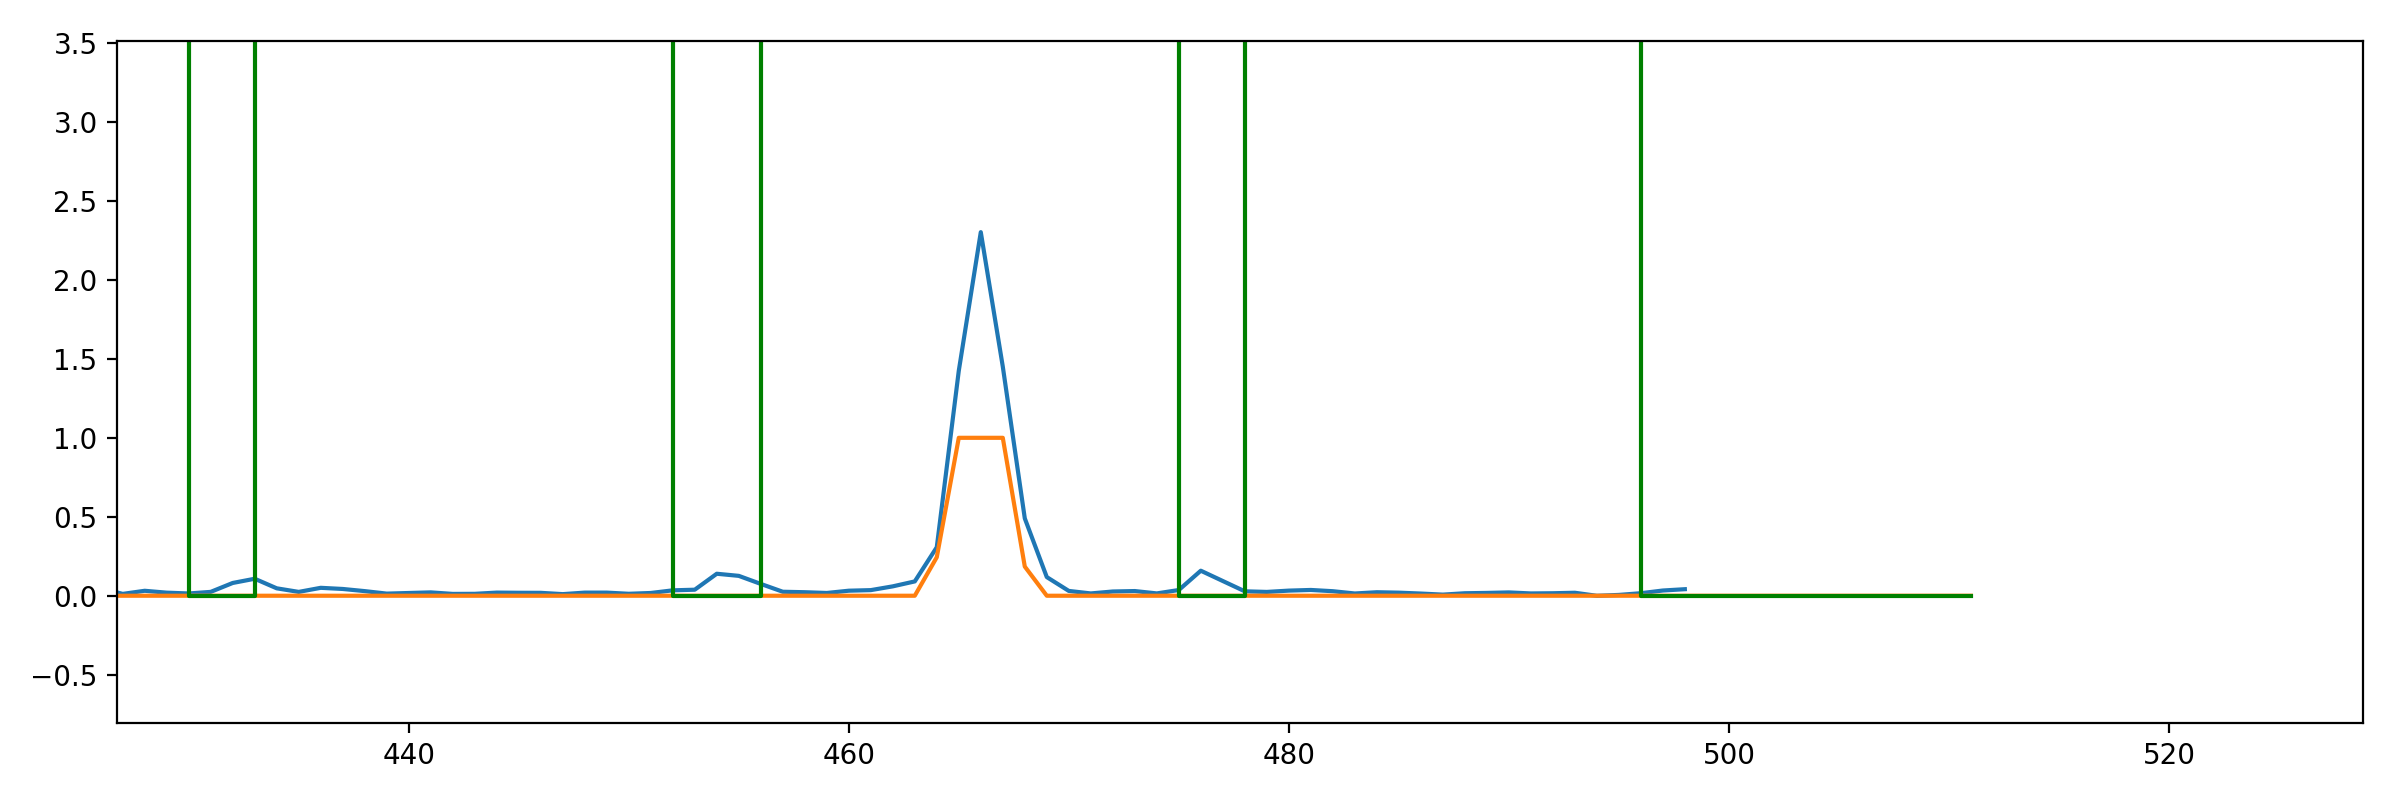

In [112]:
test = source_signal_subtrbkg/photom_img/fringe_img
plt.figure(figsize=(12,4))
plt.plot(test[512,:512])
plt.plot(weight_map[512,:512])
plt.step(d2cMaps['sliceMap'][512,:512],'g')
plt.ylim(-0.5,3)
plt.tight_layout()

<IPython.core.display.Javascript object>


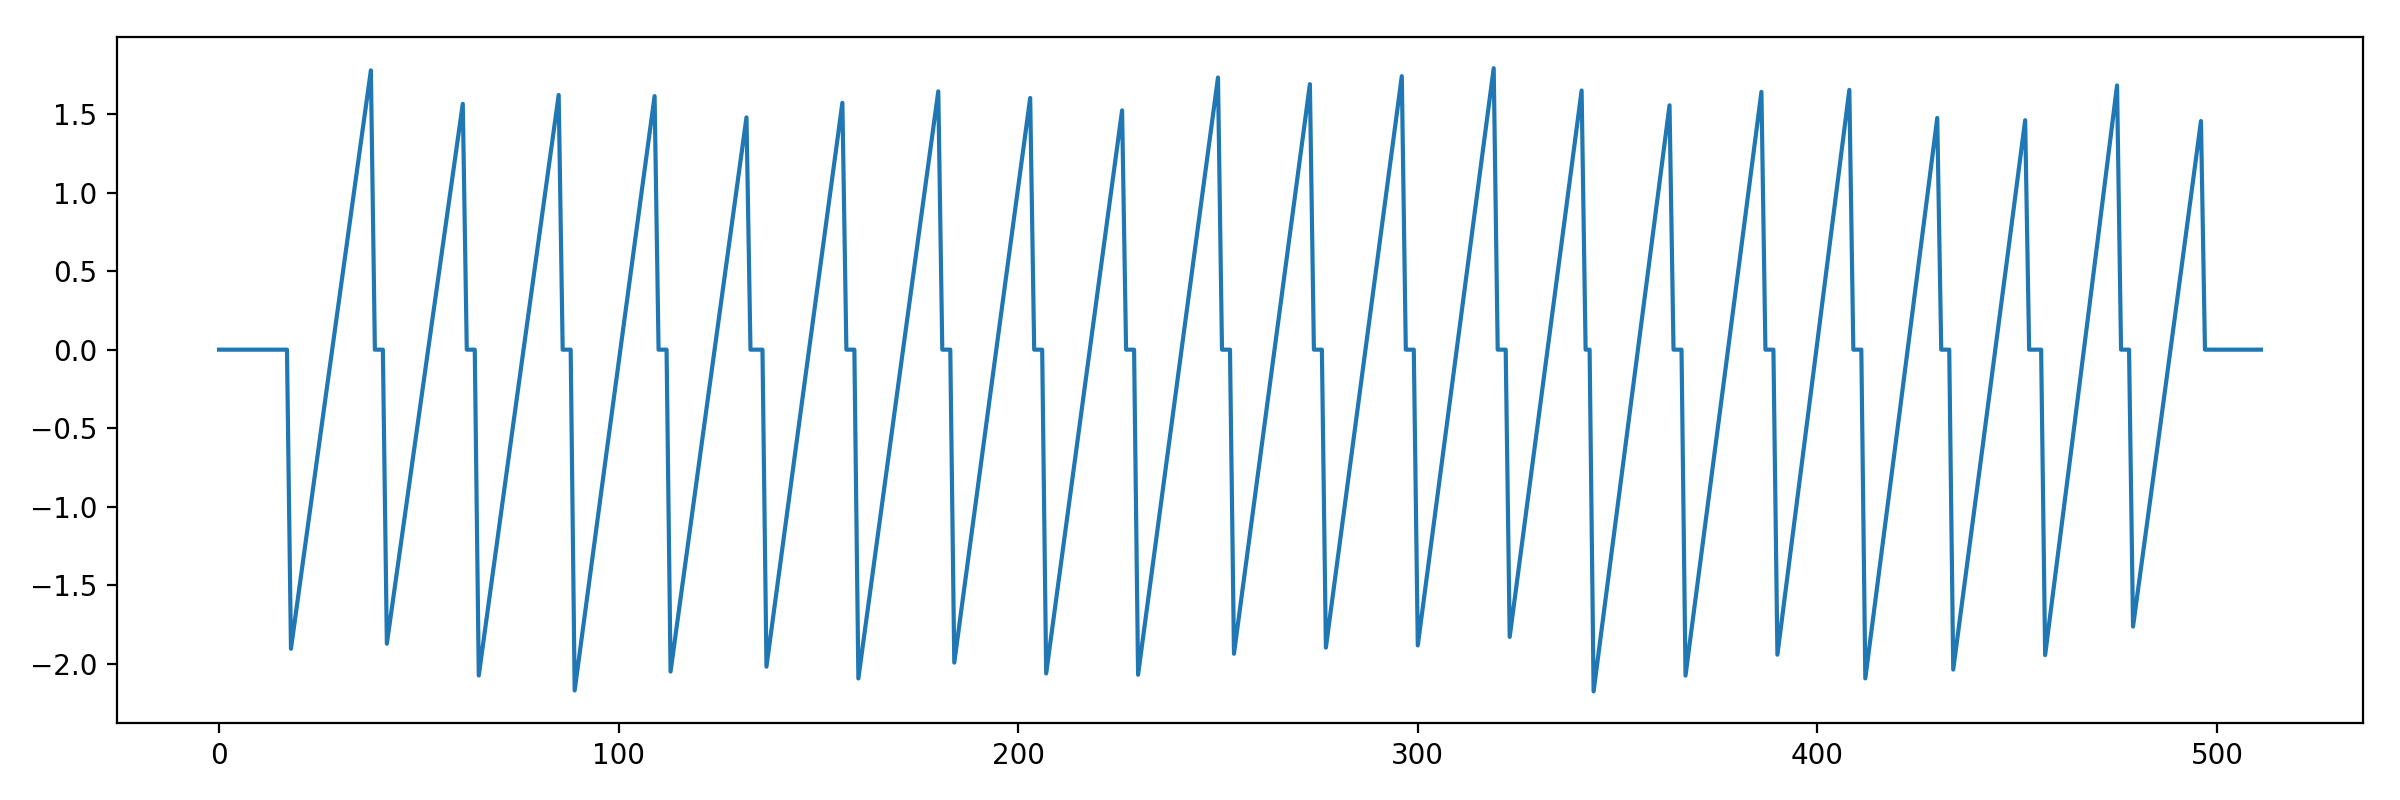

In [113]:
plt.figure(figsize=(12,4))
plt.plot(d2cMaps['alphaMap'][512,:512])
plt.tight_layout()

In [ ]:
def pixel_signal_contribution(d2cMaps,aperture,spec_grid=None):
    from shapely.geometry import Polygon
    print( 'Pixel weight mapping')
    lambcens,lambfwhms = spec_grid[0],spec_grid[1]
    weight_map = np.zeros((1024,1032))
    for ibin in range(len(lambcens)):
        if ibin%100 == 0: print( '{}/{} bins processed'.format(ibin,len(lambcens)))
        i,j = np.where(np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)
        for pix in range(len(i)):
            alphaUR = d2cMaps['alphaURMap'][i[pix],j[pix]]
            alphaUL = d2cMaps['alphaULMap'][i[pix],j[pix]]
            alphaLL = d2cMaps['alphaLLMap'][i[pix],j[pix]]
            alphaLR = d2cMaps['alphaLRMap'][i[pix],j[pix]]

            betaUR = d2cMaps['betaURMap'][i[pix],j[pix]]
            betaUL = d2cMaps['betaULMap'][i[pix],j[pix]]
            betaLL = d2cMaps['betaLLMap'][i[pix],j[pix]]
            betaLR = d2cMaps['betaLRMap'][i[pix],j[pix]]

            alphabetaUR = [alphaUR,betaUR]
            alphabetaUL = [alphaUL,betaUL]
            alphabetaLL = [alphaLL,betaLL]
            alphabetaLR = [alphaLR,betaLR]

            xy = [alphabetaUR, alphabetaUL, alphabetaLL, alphabetaLR]
            polygon_shape = Polygon(xy)

            weight_map[i[pix],j[pix]] = polygon_shape.intersection(aperture).area/polygon_shape.area
    print( '{}/{} bins processed'.format(len(lambcens),len(lambcens)))
    return weight_map